In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784",version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,y = mnist['data'],mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

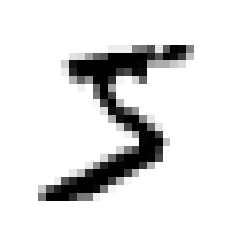

In [7]:
some_img = X[0].reshape(28,28)
plt.imshow(some_img,cmap=plt.cm.binary)
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

In [9]:
y = y.astype(np.uint8)

In [10]:
def plot_digit(data):
    img = data.reshape(28,28)
    plt.imshow(img,cmap=plt.cm.binary,interpolation="nearest")
    plt.axis('off')
    plt.show()

In [11]:
X_train,X_test,y_train,y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_train == 5)

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000,tol = 1e-3,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [14]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd_clf,X_train,y_train_5,cv=2,scoring='accuracy')

In [15]:
scores

array([0.95506667, 0.9524    ])

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits=3)

for train_idx,test_idx in skfold.split(X_train,y_train_5):
    X_train_folds = X_train[train_idx] 
    y_train_folds = y_train_5[train_idx]
    X_test_folds = X_train[test_idx]
    y_test_folds = y_train_5[test_idx]
    
    sgd_clone = clone(sgd_clf)
    sgd_clone.fit(X_train_folds,y_train_folds)
    pred_folds = sgd_clone.predict(X_test_folds)
    corrects = sum(y_test_folds == pred_folds)
    print(corrects/len(pred_folds))

0.95035
0.96035
0.9604


In [17]:
from sklearn.base import BaseEstimator

class Never5classifier(BaseEstimator):
    def fit(self, X,y=None):
        pass
    
    def predict(self,X):
        return np.zeros((len(X),1),dtype="bool")

In [18]:
n5c = Never5classifier()

In [19]:
scores = cross_val_score(n5c,X_train,y_train_5,cv=3,scoring='accuracy')

In [20]:
scores

array([0.91125, 0.90855, 0.90915])

In [21]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [22]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [23]:
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [24]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [25]:
f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [26]:
some_digit = X[0]
y_scores = sgd_clf.decision_function([X[0]])
y_scores

array([2164.22030239])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [28]:
y_some_digit_pred

array([ True])

In [29]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [31]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

In [32]:
thresholds.shape,recalls.shape

((59966,), (59967,))

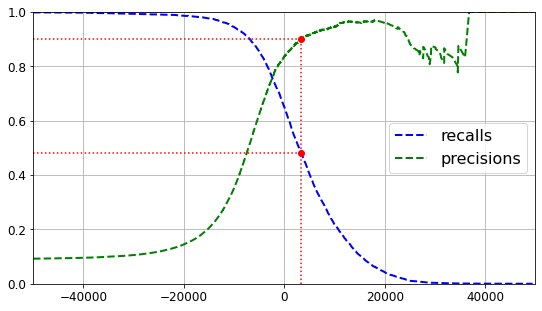

In [33]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,recalls[:-1],"b--",label="recalls",linewidth=2)
    plt.plot(thresholds,precisions[:-1],"g--",label="precisions",linewidth=2)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]    
thresh_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
    
plt.figure(figsize=(9,5))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.plot([thresh_90_precision,thresh_90_precision],[0.,0.9],"r:")
plt.plot([-50000,thresh_90_precision],[0.9,0.9],'r:')
plt.plot([-50000,thresh_90_precision],[recall_90_precision,recall_90_precision],"r:")
plt.plot([thresh_90_precision],[0.9],"ro")
plt.plot([thresh_90_precision],[recall_90_precision],"ro")
plt.show()

In [34]:
thresh_90_precision

3370.0194991439557

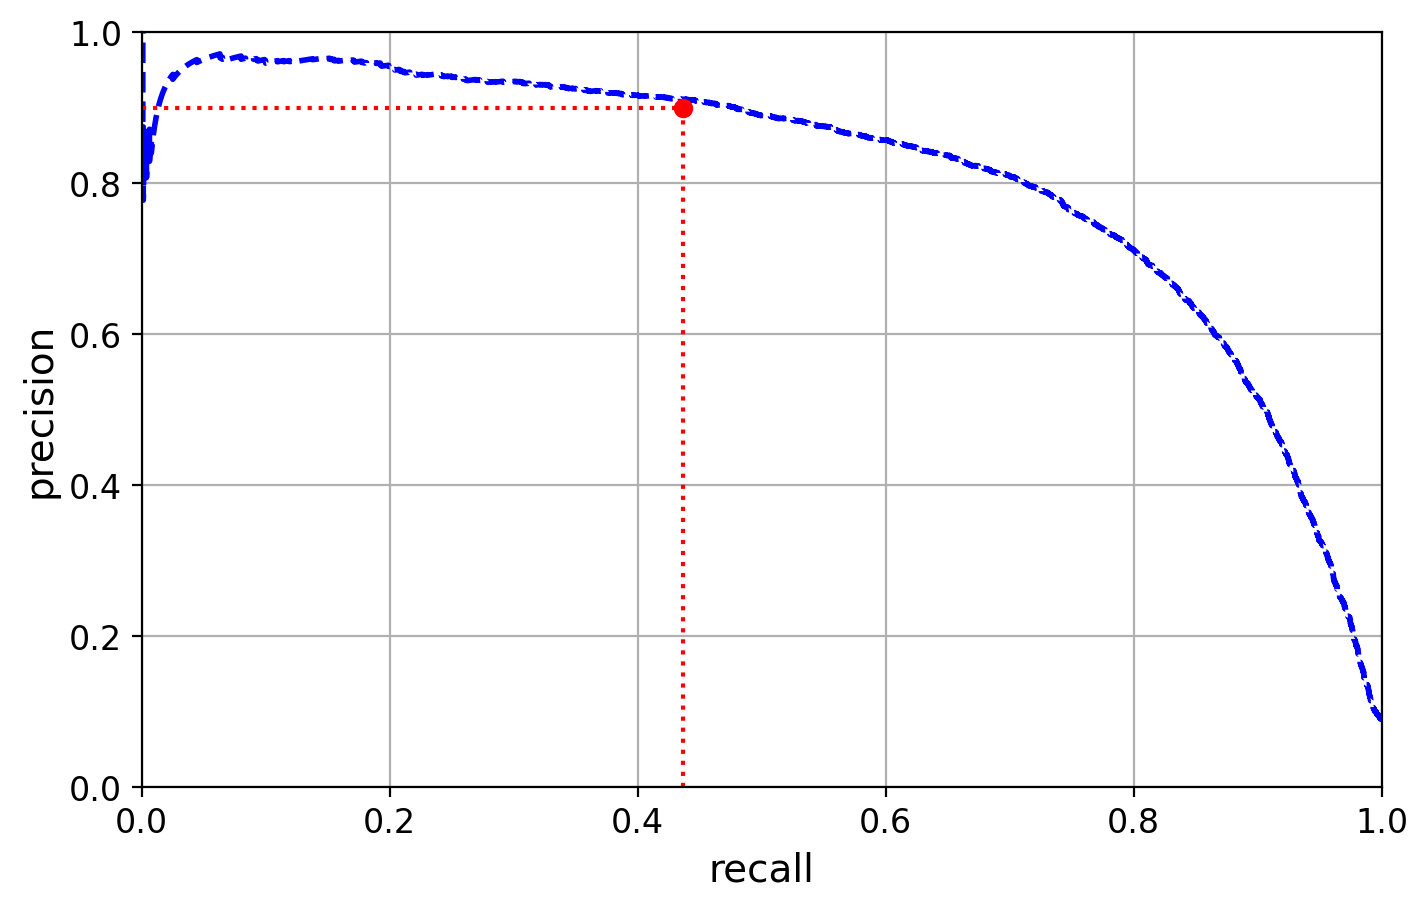

In [35]:
def precision_vs_recall_curve(precision,recall):
    plt.plot(recall,precision,'b--',linewidth=2)
    plt.ylabel("precision")
    plt.xlabel("recall")
    plt.axis([0,1,0,1])
    plt.grid(True)
    
plt.figure(figsize=(8,5),dpi=200)
precision_vs_recall_curve(precisions,recalls)
plt.plot([.4368,.4368],[0.,0.9],'r:')
plt.plot([0.,.4368],[0.9,0.9],'r:')
plt.plot([.4368],[0.9],'ro')
plt.show()

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
pred_90_precision = y_scores >= threshold

In [37]:
thresh_90_precision

3370.0194991439557

In [38]:
pred_90_precision

array([False, False, False, ...,  True, False, False])

In [39]:
precision_score(y_train_5,pred_90_precision)

0.9346130773845231

In [40]:
recall_score(y_train_5,pred_90_precision)

0.2874008485519277

### Multiclass Classification

In [41]:
from sklearn.svm import SVC
svc_cf = SVC(gamma="auto",random_state=42)
svc_cf.fit(X_train[:1000],y_train[:1000])

SVC(gamma='auto', random_state=42)

In [42]:
some_digit_score = svc_cf.decision_function([some_digit])
some_digit_score

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [43]:
np.argmax(some_digit_score)

5

In [44]:
svc_cf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
svc_cf.classes_[5]

5

In [46]:
from sklearn.multiclass import OneVsOneClassifier

In [47]:
ova_clf = OneVsOneClassifier(SVC(gamma="auto",random_state=42))
ova_clf.fit(X_train[:1000],y_train[:1000])

OneVsOneClassifier(estimator=SVC(gamma='auto', random_state=42))

In [48]:
some_digit_pred = ova_clf.predict([some_digit])

In [49]:
some_digit_pred

array([5], dtype=uint8)

In [50]:
len(ova_clf.estimators_)

45

In [51]:
sgd_clf.fit(X_train,y_train)

SGDClassifier(random_state=42)

In [52]:
sgd_clf.predict([X[2]])

array([4], dtype=uint8)

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_train,sgd_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.91      0.94      5923
           1       0.98      0.96      0.97      6742
           2       0.93      0.82      0.88      5958
           3       0.78      0.92      0.85      6131
           4       0.96      0.80      0.87      5842
           5       0.86      0.80      0.83      5421
           6       0.97      0.91      0.94      5918
           7       0.95      0.91      0.92      6265
           8       0.67      0.90      0.77      5851
           9       0.83      0.87      0.85      5949

    accuracy                           0.88     60000
   macro avg       0.89      0.88      0.88     60000
weighted avg       0.89      0.88      0.88     60000



In [54]:
sgd_clf.decision_function([some_digit]).shape

(1, 10)

In [55]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sgd_clf.fit(sc.fit_transform(X_train),y_train)
print(classification_report(y_train,sgd_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.71      0.99      0.82      5923
           1       0.94      0.97      0.96      6742
           2       0.92      0.81      0.86      5958
           3       0.63      0.91      0.74      6131
           4       0.81      0.94      0.87      5842
           5       0.98      0.38      0.55      5421
           6       0.88      0.95      0.91      5918
           7       0.98      0.79      0.87      6265
           8       0.73      0.64      0.68      5851
           9       0.86      0.74      0.80      5949

    accuracy                           0.82     60000
   macro avg       0.84      0.81      0.81     60000
weighted avg       0.84      0.82      0.81     60000



In [56]:
y_train_pred = sgd_clf.predict(X_train)
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_train,y_train_pred)

In [57]:
print(cf)

[[5867    0    0    4    8    0   12    0   32    0]
 [   4 6538   43   83    9    1   16    3   38    7]
 [ 297   49 4817  262  131    1  253   24  116    8]
 [ 239   14   73 5589   10   15   49   14   75   53]
 [ 101   18    9   42 5478    1   56    1   66   70]
 [ 791   78   35 1010  146 2062  276    7  840  176]
 [ 181   11    9    7   67    4 5609    0   30    0]
 [ 391   34  130  224  152    5    8 4925  112  284]
 [ 237  152  106 1321   13    9  121    0 3765  127]
 [ 197   48   24  341  751    3    1   63  117 4404]]


### Multilabel Classification

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 != 0)

y_train_multilabel = np.c_[y_train_large,y_train_odd]

knn_cf = KNeighborsClassifier()
knn_cf.fit(X_train,y_train_multilabel)

KNeighborsClassifier()

In [59]:
knn_cf.predict([X_train[0]])

array([[False,  True]])

In [60]:
y_train_multilabel[0]

array([False,  True])

In [63]:
rand_idx = np.random.randint(1,X_train.shape[0],1000)

In [66]:
print(classification_report(y_train_multilabel[rand_idx],knn_cf.predict(X_train[rand_idx])))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       258
           1       0.98      1.00      0.99       478

   micro avg       0.99      0.99      0.99       736
   macro avg       0.99      0.99      0.99       736
weighted avg       0.99      0.99      0.99       736
 samples avg       0.56      0.56      0.56       736



C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train_multilabel[rand_idx],knn_cf.predict(X_train[rand_idx])))

0.988


### Multioutput Classification

In [68]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mode = X_test

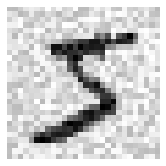

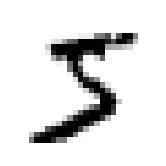

In [77]:
some_index = 0
plt.subplot(121); plot_digit(X_train_mod[some_index])
plt.subplot(122); plot_digit(y_train_mod[some_index])
plt.show()

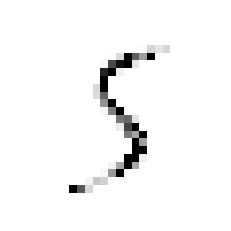

In [78]:
knn_cf.fit(X_train_mod,y_train_mod)
cleaned_digit = knn_cf.predict([some_digit])
plot_digit(cleaned_digit)

### Extra material

In [81]:
knn_cf = KNeighborsClassifier(weights="distance",n_neighbors=4,n_jobs=-1)
knn_cf.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [82]:
y_pred_final = knn_cf.predict(X_test)
print(accuracy_score(y_test,y_pred_final))

0.9714


In [83]:
from scipy.ndimage.interpolation import shift

In [101]:
def shift_image(img_array,dx,dy,new=0):

    return shift(img_array.reshape(28,28),[dx,dy],cval=new).reshape(784)

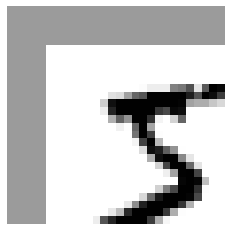

In [102]:
plot_digit(shift_image(some_digit,5,5,new=100))

In [114]:
b = np.array([[8,1,7], [4,3,9], [5,2,6]])
np.apply_along_axis(sorted, 1, b)

array([[1, 7, 8],
       [3, 4, 9],
       [2, 5, 6]])

## Exercises

In [ ]:
# from sklearn.model_selection import GridSearchCV
# knn_cf = KNeighborsClassifier()
# param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

# grid_search = GridSearchCV(knn_cf,param_grid,cv=3,njobs=-1)
# grid_search.fit(X_train,y_train)

## Data Augmentation

In [126]:
from scipy.ndimage.interpolation import shift

def shift_image(img_arr,dx,dy):
    return shift(img_arr.reshape([28,28]),[dx,dy],cval=0,mode="constant")

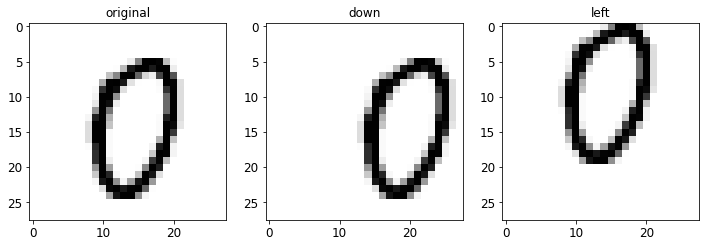

In [128]:
image = X_train[1000]
shifted_image_down = shift_image(image,0,5)
shifted_image_left = shift_image(image,-5,0)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("original")
plt.imshow(X_train[1000].reshape([28,28]),interpolation="nearest", cmap="Greys")

plt.subplot(132)
plt.title("down")
plt.imshow(shifted_image_down,interpolation="nearest", cmap="Greys")

plt.subplot(133)
plt.title("left")
plt.imshow(shifted_image_left,interpolation="nearest", cmap="Greys")

plt.show()

In [ ]:
#####
def shift_image(img_arr,dx,dy):
    return shift(img_arr.reshape([28,28]),[dx,dy],cval=0,mode="constant").reshape([-1])

In [ ]:
X_train_augmented = [train for train in X_train]
y_train_augmented = [label for label in y_train]

for dx,dy in ((1,0),(-1,0),(0,1),(0,-1)):
    for image,label in zip(X_train_augmented,y_train_augmented):
        shifted_image = shift_image(image,dx,dy)
        X_train_augmented.append(shifted_image)
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
X_train_augmented.shape, y_train_augmented.shape